# Activation stats

In [1]:
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [2]:
import torch.nn.functional as F,matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [3]:
%matplotlib inline

In [4]:
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

Loading smaller sample of data so as to train on cpu faster

In [5]:
import datasets

x,y = 'image','label'
name = "fashion_mnist"
train_ds = load_dataset(name, split='train[:20%]')
test_ds = load_dataset(name, split='test[:20%]')

dsd = datasets.DatasetDict({"train":train_ds,"test":test_ds})
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2000
    })
})

In [6]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]
    
bs = 64
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([64, 1, 28, 28]), tensor([6, 9, 3, 0, 1, 4, 0, 0, 4, 7]))

## Baseline

In [7]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

We want to train quickly, so that means training at a high learning rate.

In [10]:
from torcheval.metrics import MulticlassAccuracy

In [11]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [12]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs + fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.153,2.273,0,train
0.097,2.304,0,eval


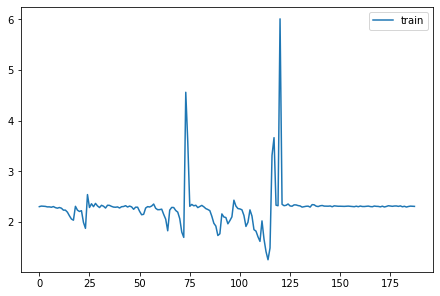

In [13]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))